In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import warnings
import json
from itertools import combinations

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [26]:
#Add functions for Univariate analysis
def describe_numerical_col(df, col_name):
    info = df[[col_name]].describe().to_dict()[col_name]
    info['shapiro'] = f'{stats.shapiro(df[col_name])[1]: .5f}'
    info['normal'] = float(info['shapiro']) > 0.05
    info['missing'] = df[col_name].isna().sum()
    info['skew'] = f'{stats.skew(df[col_name]):.5f}'
    info['type'] = ('slight ' if info['normal'] else '') +\
        ('right(positive)' if float(info['skew']) > 0 else 'left(negative)') + '-skew'

    fig, ax = plt.subplots(2, 2, figsize=(16, 7), gridspec_kw={'height_ratios':(.85, .15)})
    sns.histplot(df[col_name], kde=True, ax=ax[0, 0], color='#55A868')
    sns.boxplot(df[col_name], orient='h', ax=ax[1, 0], color="#5583A8")
    counts, bin_edges = np.histogram(df[col_name], bins=10, density = True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    ax[1, 1] = plt.subplot(122)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.legend()
    ax[0, 0].set_xticklabels([])
    ax[1, 0].set_yticklabels([])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('Count')
    fig.suptitle(col_name, fontsize=30)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(info_df)
    print('='*40)
    
def categorize_numerical_col(col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)

def describe_categorical_col(df, col_name):
    counts = pd.DataFrame(df[col_name].value_counts()).reset_index()
    counts.columns = ['Group', 'Count']
    total = sum(counts['Count'])
    counts['%'] = (counts['Count'] / total * 100).round(2)

    fig = px.pie(
        counts,
        names='Group',
        values='Count',
        title=f'<b>Distribution of {col_name} in each group</b>',
        color='Group',
        hole=0.3
    )

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',

    )

    fig.update_layout(
        title_x=0.5,
        legend_title_text='Groups',
        font=dict(family="Arial, sans-serif", size=14)
    )
    fig.show()
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(counts)
    print('='*40)
    # plt.figure(figsize=(12, 7))
    # ax = sns.barplot(
    #     data=counts,
    #     x=counts[col_name],
    #     y=counts['count'],
    #     palette='viridis'
    # )

    # for i in range(len(ax.patches)):
    #     p = ax.patches[i]
    #     percentage = counts['percents'][i]
    #     ax.annotate(f'{percentage:.2f}%',
    #                 (p.get_x() + p.get_width()/2., p.get_height()),
    #                 ha='center', va='center',
    #                 fontsize=11, color='black',
    #                 xytext=(0, 10),
    #                 textcoords='offset points')
    
    # plt.ylim(0, max(counts['count']) * 1.15)
    # ax.set_xlabel('')
    # ax.set_title(f'Distribution of {col_name} in each group')
    # plt.show()

def describe_num_num_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر عددی"""
    # آزمون نرمال بودن با شاپیرو
    shapiro1_stat, shapiro1_p = stats.shapiro(df[col1])
    shapiro2_stat, shapiro2_p = stats.shapiro(df[col2])
    
    # تشخیص نرمال بودن (p > 0.05 یعنی نرمال)
    is_normal1 = shapiro1_p > 0.05
    is_normal2 = shapiro2_p > 0.05
    both_normal = is_normal1 & is_normal2
    
    # انتخاب آزمون مناسب
    if both_normal:
        # استفاده از پیرسون
        corr_stat, p_value = stats.pearsonr(df[col1], df[col2])
        test_used = 'Pearson'
        correlation = corr_stat
    else:
        # استفاده از اسپیرمن
        corr_stat, p_value = stats.spearmanr(df[col1], df[col2])
        test_used = 'Spearman'
        correlation = corr_stat
    
    r2_score = correlation ** 2
    
    info = {
        'shapiro_p_col1': f'{shapiro1_p:.5f}',
        'shapiro_p_col2': f'{shapiro2_p:.5f}',
        'col1_normal': is_normal1,
        'col2_normal': is_normal2,
        'test_used': test_used,
        'correlation': f'{correlation:.5f}',
        'r_squared': f'{r2_score:.5f}',
        'p_value': f'{p_value:.5f}',
        'significant': p_value < 0.05,
        'relationship_strength': 'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.3 else 'weak',
        'relationship_direction': 'positive' if correlation > 0 else 'negative'
    }
    
    # رسم نمودار
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{col1} vs {col2} - {test_used} Correlation', fontsize=14)

    # Scatter Plot
    axes[0].scatter(df[col1], df[col2],
                    s=60, alpha=0.7, color='blue', edgecolors='black', linewidth=0.5)
    axes[0].set_title('Scatter Plot')
    axes[0].set_xlabel(col1)
    axes[0].set_ylabel(col2)
    axes[0].grid(True, alpha=0.3)

    # Hexbin Plot
    axes[1].hexbin(df[col1], df[col2], gridsize=20, cmap='Blues', mincnt=1)
    axes[1].set_title('Hexbin Plot')
    axes[1].set_xlabel(col1)
    axes[1].set_ylabel(col2)
    axes[1].yaxis.set_label_position("right")
    
    plt.tight_layout()
    plt.show()
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*15 + f' {col1} vs {col2} ' + '='*15)
    print(info_df)
    print('='*50)

def describe_cat_num_relationship(df, cat_col, num_col):
    """تحلیل رابطه بین متغیر کیفی و کمی"""
    
    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Box plot
    sns.boxplot(data=df, x=cat_col, y=num_col, ax=axs[0, 0])
    axs[0, 0].set_title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=45)
    
    # Violin plot
    sns.violinplot(data=df, x=cat_col, y=num_col, ax=axs[0, 1])
    axs[0, 1].set_title(f'{num_col} Distribution by {cat_col}')
    plt.xticks(rotation=45)
    
    # Bar plot of means
    means = df.groupby(cat_col)[num_col].mean().sort_values(ascending=False)
    sns.barplot(x=means.index, y=means.values, ax=axs[1, 0])
    axs[1, 0].set_title(f'Mean {num_col} by {cat_col}')
    plt.xticks(rotation=45)
    
    # Count plot of categories
    sns.countplot(data=df, x=cat_col, ax=axs[1, 1])
    axs[1, 1].set_title(f'Count of {cat_col}')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    

def describe_cat_cat_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر کیفی"""
    # جدول تطبیقی
    contingency_table = pd.crosstab(df[col1], df[col2])
    normalized = pd.crosstab(df[col1], df[col2], normalize='index')
    
    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Heatmap of contingency table
    sns.heatmap(contingency_table, annot=True, cbar=False ,fmt='d', cmap=['White'], ax=axs[0, 0], linecolor='lightgray', linewidths=0.7)
    axs[0, 0].set_title(f'Contingency Table: {col1} vs {col2}')
    
    # Stacked bar chart 100%
    normalized.plot.bar(stacked=True, ax=axs[0, 1])
    axs[0, 1].set_title(f'Stacked Bar: {col1} vs {col2}')
    axs[0, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    
    # Normalized heatmap (percentages)
    sns.heatmap(normalized, annot=True, fmt='.2%', cbar=False, cmap=['White'], ax=axs[1, 0], linecolor='lightgray', linewidths=0.7)
    axs[1, 0].set_title(f'Normalized Contingency Table')
    
    # Count plots side by side
    contingency_table.plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title(f'Count Comparison')
    axs[1, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    

def describe_target_relationship(df, feature_col, target_col):
    """تحلیل رابطه هر متغیر با متغیر هدف"""
    if df[feature_col].dtype in ['object', 'category']:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_cat_relationship(df, feature_col, target_col)
        else:
            describe_cat_num_relationship(df, feature_col, target_col)
    else:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_num_relationship(df, target_col, feature_col)
        else:
            describe_num_num_relationship(df, feature_col, target_col)

#non_prarametric

def numeric_nonparm_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.wilcoxon(data - np.median(data))
        result["test"] = "Wilcoxon"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        result["test"] = "Man-Whitney-U"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.kruskal(*groups)
        result["test"] = "Kruskal"

    elif test_type == "variance-test":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.friedmanchisquare(*groups)
        result["test"] = "Friedman"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

#parametric
def numeric_parametric_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.ttest_1samp(data, np.mean(data))
        result["test"] = "Ttest"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
        result["test"] = "Ttest"

    elif test_type == "paired":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_rel(group1, group1)
        result["test"] = "Ttest"

    elif test_type == "non-equal-var":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        result["test"] = "Welch"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.f_oneway(*groups)
        result["test"] = "One-Way ANOVA"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

        if p_value < alpha:
            print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        else:
            print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")


In [2]:
def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

        if p_value < alpha:
            print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        else:
            print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")


In [3]:
df = pd.read_csv('marketing.csv')

In [4]:
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,13300,36,Female,47648.0,Email,Consideration,893.7554921892273,0.132078,0.198063,38,6.900081,11.923316,9,3,6,1,1139,IsConfid,ToolConfid,1
1,10429,32,Female,47491.0,Email,Consideration,7330.251375088103,0.120810,0.088416,27,4.589390,NaN,33,0,2,4,3772,IsConfid,ToolConfid,1
2,10557,52,Male,83830.0,Referral,Awareness,7720.360685483039,0.125472,0.082197,35,7.403157,0.660581,29,1,3,0,3611,IsConfid,ToolConfid,1
3,12602,52,Male,116342.0,Social Media,Consideration,8337.45315727269,0.158739,0.089032,25,9.367090,12.218421,72,3,7,4,1173,IsConfid,ToolConfid,1
4,8592,58,Female,90994.0,Email,Retention,5273.098832292671,0.226054,0.099792,13,7.968767,4.894079,41,16,7,0,1102,IsConfid,ToolConfid,1


In [5]:
df.isna().sum()

CustomerID               0
Age                      0
Gender                   0
Income                  79
CampaignChannel        154
CampaignType             0
AdSpend                  0
ClickThroughRate         0
ConversionRate           0
WebsiteVisits            0
PagesPerVisit            0
TimeOnSite              79
SocialShares             0
EmailOpens               0
EmailClicks              0
PreviousPurchases        0
LoyaltyPoints            0
AdvertisingPlatform      0
AdvertisingTool          0
Conversion               0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2010 non-null   int64  
 1   Age                  2010 non-null   int64  
 2   Gender               2010 non-null   object 
 3   Income               1931 non-null   float64
 4   CampaignChannel      1856 non-null   object 
 5   CampaignType         2010 non-null   object 
 6   AdSpend              2010 non-null   object 
 7   ClickThroughRate     2010 non-null   float64
 8   ConversionRate       2010 non-null   float64
 9   WebsiteVisits        2010 non-null   int64  
 10  PagesPerVisit        2010 non-null   float64
 11  TimeOnSite           1931 non-null   float64
 12  SocialShares         2010 non-null   int64  
 13  EmailOpens           2010 non-null   int64  
 14  EmailClicks          2010 non-null   int64  
 15  PreviousPurchases    2010 non-null   i

As we can see all the types seems to be ok but Adspend which should be a numerical value

In [7]:
df.nunique()

CustomerID             2010
Age                      52
Gender                    2
Income                 1923
CampaignChannel           6
CampaignType              4
AdSpend                2010
ClickThroughRate       2010
ConversionRate         2010
WebsiteVisits            50
PagesPerVisit          2010
TimeOnSite             1931
SocialShares            100
EmailOpens               20
EmailClicks              23
PreviousPurchases        10
LoyaltyPoints          1659
AdvertisingPlatform       1
AdvertisingTool           1
Conversion                2
dtype: int64

Advertising Tool and Advertising Platform have only one unique value, therefore don't provide much information for us

<h1>Univariate Analysis & Data Cleanning</h1>

<h3>Campaign Channel

In [8]:
describe_categorical_col(df, 'CampaignChannel')

================== CampaignChannel ==================
          Group  Count      %
0           PPC    422  22.74
1      Referral    404  21.77
2  Social Media    343  18.48
3           SEO    334  18.00
4         Email    247  13.31
5         email    106   5.71


As we can see, Email and email are two separate groups which is wrong and we need to merge them

In [9]:
df['CampaignChannel'] = df['CampaignChannel'].str.replace('email', 'Email')

In [10]:
describe_categorical_col(df, 'CampaignChannel')

================== CampaignChannel ==================
          Group  Count      %
0           PPC    422  22.74
1      Referral    404  21.77
2         Email    353  19.02
3  Social Media    343  18.48
4           SEO    334  18.00


Okay, everything is good so far. let's go for the missing values

In [11]:
df['CampaignChannel'].isna().sum()

154

In [12]:
bins=[18, 30, 45, 60, 70]
bin_labels = ['Young', 'Adult', 'Middle-Aged', 'Old']
categorize_numerical_col('Age', bins=bins, bins_name=bin_labels)

In [13]:
df[df['CampaignChannel'].isna()][['Age_categorized']].value_counts()

Age_categorized
Adult              55
Middle-Aged        49
Old                29
Young              17
Name: count, dtype: int64

In [14]:
for camp in ['Referral', 'PPC', 'Email', 'SEO', 'Social Media']:
    male = df[df['CampaignChannel'] == camp][['Gender']].value_counts()['Male']
    female = df[df['CampaignChannel'] == camp][['Gender']].value_counts()['Female']
    print(f'male to female ratio for {camp}: {male/female}')

male to female ratio for Referral: 0.7046413502109705
male to female ratio for PPC: 0.5687732342007435
male to female ratio for Email: 0.5829596412556054
male to female ratio for SEO: 0.5829383886255924
male to female ratio for Social Media: 0.9055555555555556


In [15]:
male = df[df['CampaignChannel'].isna()][['Gender']].value_counts()['Male']
female = df[df['CampaignChannel'].isna()][['Gender']].value_counts()['Female']
print(f'male to female ratio for {camp}: {male/female}')

male to female ratio for Social Media: 0.49514563106796117


The missing data are not small so if we just replace them with mode, it may conciderbly affect the analysis. Therefore, we create 'Other' to solve this.

In [16]:
df['CampaignChannel'] = df['CampaignChannel'].fillna('Other')

In [17]:
describe_categorical_col(df, 'CampaignChannel')

================== CampaignChannel ==================
          Group  Count      %
0           PPC    422  21.00
1      Referral    404  20.10
2         Email    353  17.56
3  Social Media    343  17.06
4           SEO    334  16.62
5         Other    154   7.66


As we can see PPC or PayPerClick campaign has the most amount of users but not by far. 

--------------

<h3>CampaignType</h3>

In [18]:
describe_categorical_col(df, 'CampaignType')

================== CampaignType ==================
           Group  Count      %
0     Conversion    539  26.82
1  Consideration    502  24.98
2      Retention    490  24.38
3      Awareness    479  23.83


No missing data here, and users are nearly eaqually distributed between campaign types.

------------------------------------------

<h3>AdvertisingPlatform</h3>

In [19]:
describe_categorical_col(df, 'AdvertisingPlatform')

================== AdvertisingPlatform ==================
      Group  Count      %
0  IsConfid   2010  100.0


As we can see this column has only one value so we can neglect it.

-----------------

<h3>AdvertisingTool</h3>

In [20]:
describe_categorical_col(df, 'AdvertisingTool')

================== AdvertisingTool ==================
        Group  Count      %
0  ToolConfid   2010  100.0


Same goes with this column

----------------------

-----------------

<h1>Bivariate</h1>

<h3>CampaignChannel<h3>

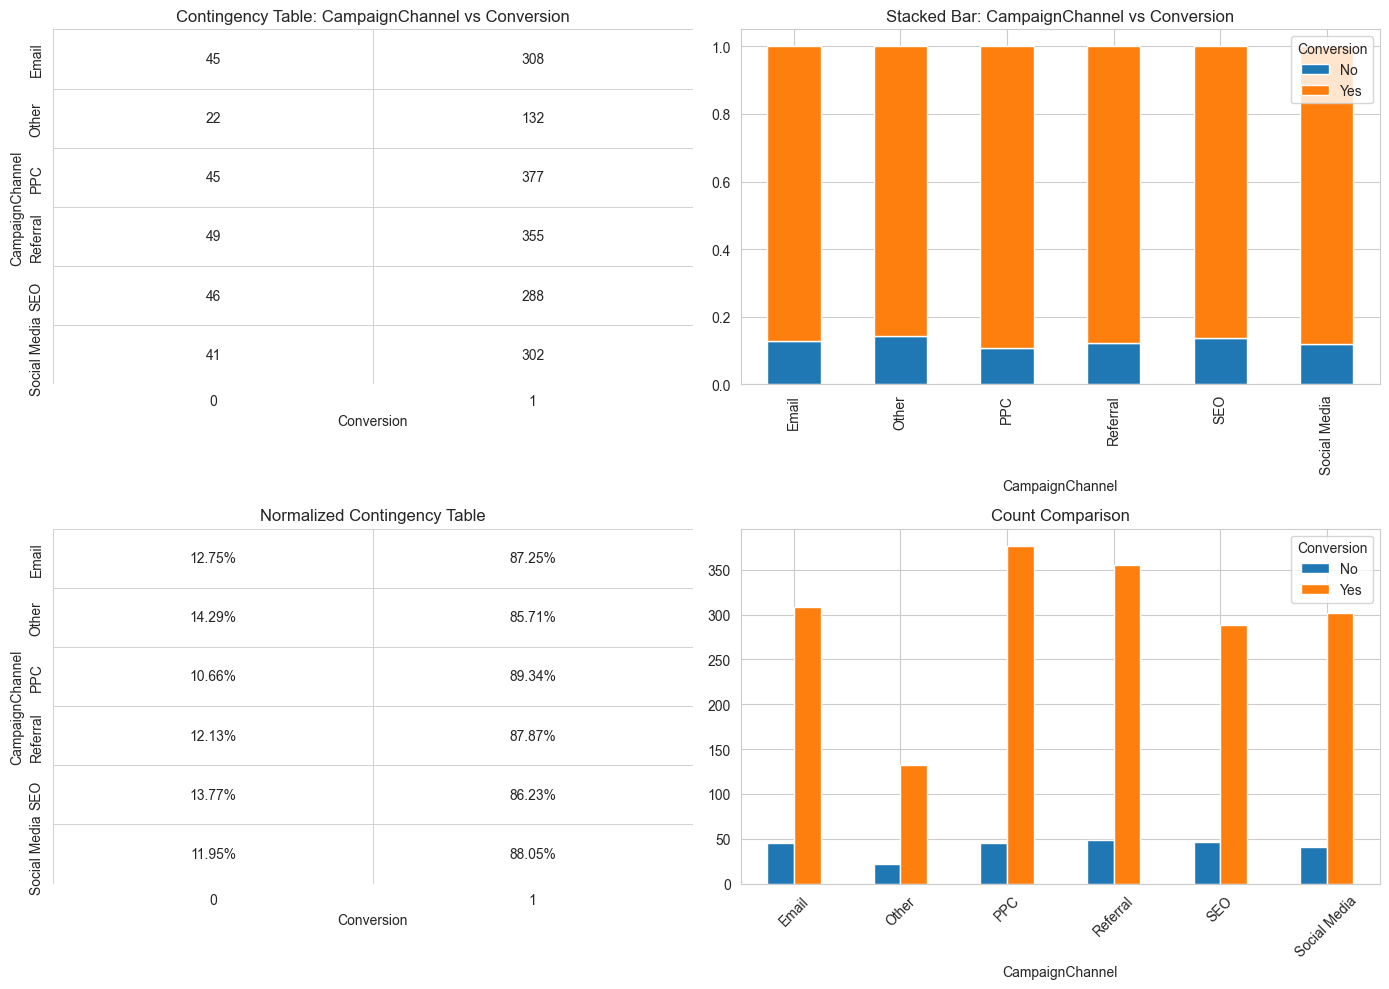

In [21]:
describe_cat_cat_relationship(df, 'CampaignChannel', 'Conversion')

In [22]:
categorical_tests('vs-target', df, 'CampaignChannel', 'Conversion')

{
   "categories vs target": "vs-target",
   "chi2_stat": 2.387650504727112,
   "p_value": 0.7933117733845269,
   "degrees_of_freedom": 5,
   "contingency_table": {
      "0": {
         "Email": 45,
         "Other": 22,
         "PPC": 45,
         "Referral": 49,
         "SEO": 46,
         "Social Media": 41
      },
      "1": {
         "Email": 308,
         "Other": 132,
         "PPC": 377,
         "Referral": 355,
         "SEO": 288,
         "Social Media": 302
      }
   }
}


As we can see from the plots and the tests the CampaignChannl does not by itself has effect on conversion.

------------------------

<h3>CampaignType</h3>

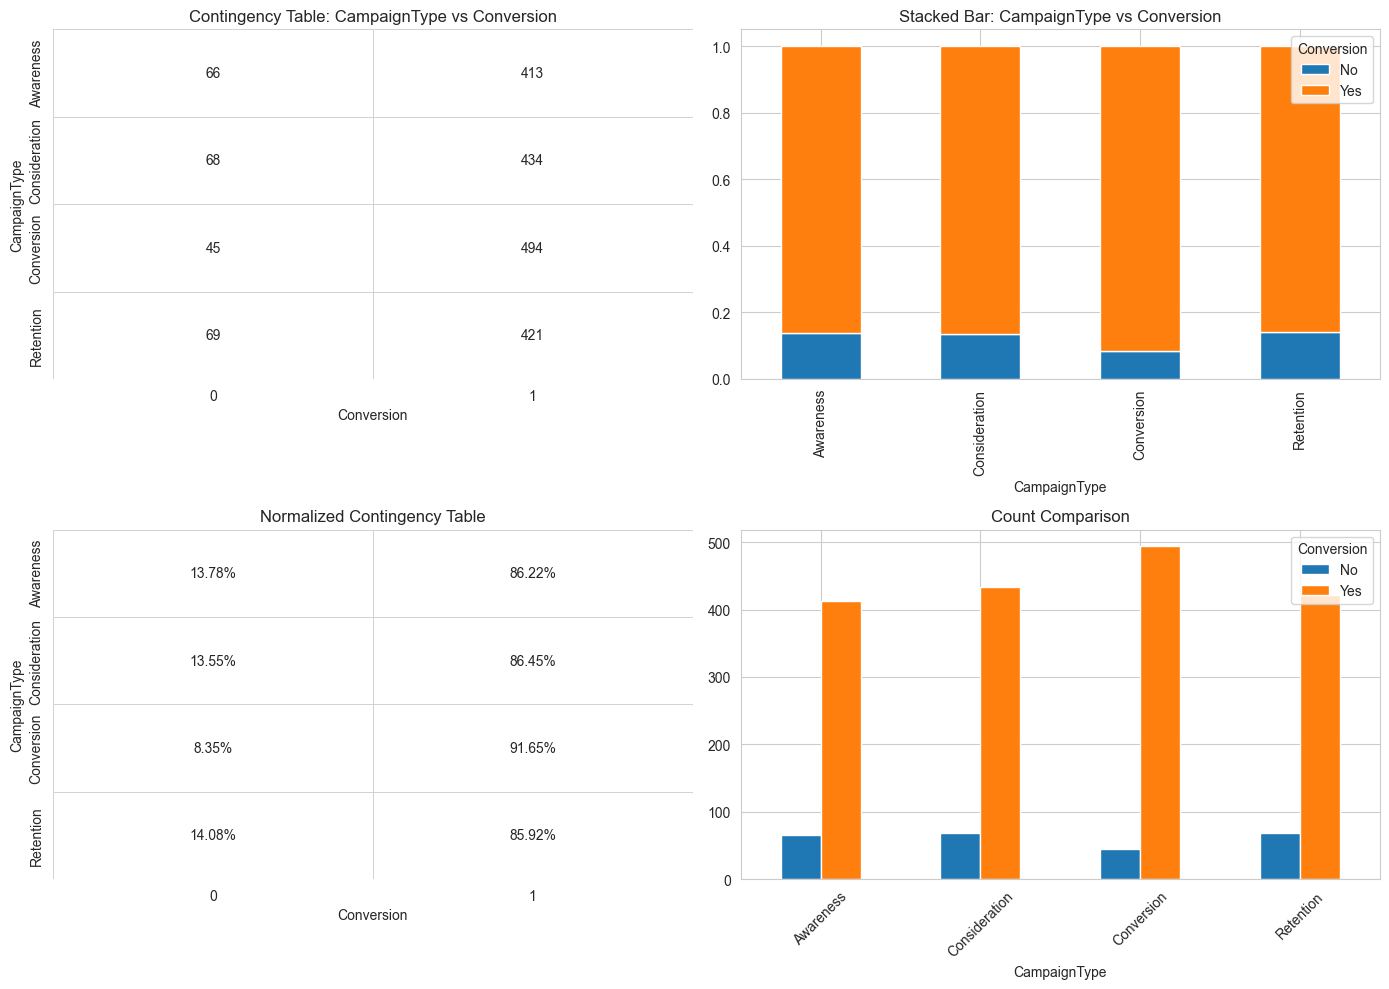

In [23]:
describe_cat_cat_relationship(df, 'CampaignType', 'Conversion')

In [24]:
categorical_tests('vs-target', df, 'CampaignType', 'Conversion')

{
   "categories vs target": "vs-target",
   "chi2_stat": 10.904061247629281,
   "p_value": 0.012256127085598723,
   "degrees_of_freedom": 3,
   "contingency_table": {
      "0": {
         "Awareness": 66,
         "Consideration": 68,
         "Conversion": 45,
         "Retention": 69
      },
      "1": {
         "Awareness": 413,
         "Consideration": 434,
         "Conversion": 494,
         "Retention": 421
      }
   }
}


Here, from the plots we can see that conversion champaign type has more conversion than other groups ans also the chi2 statistical test shows us that CampaignType does have affect on Conversion

---------------------

تحلیل دو‌متغیره

In [3]:
# 1. Age vs Conversion
print("\n<h3>Age vs Conversion</h3>")
describe_target_relationship(df, 'Age', 'Conversion')
# تست آماری
data_group1 = df[df['Conversion'] == 1]['Age'].values
data_group2 = df[df['Conversion'] == 0]['Age'].values
if len(data_group2) > 0:  # اگر داده برای Conversion=0 وجود داشت
    numeric_nonparm_test("two-independent", data_group1, data_group2)
else:
    print("تحلیل Age vs Conversion ممکن نیست چون همه Conversion=1 هستند.")

# 2. Gender vs Conversion
print("\n<h3>Gender vs Conversion</h3>")
describe_cat_cat_relationship(df, 'Gender', 'Conversion')
categorical_tests('vs-target', df, 'Gender', 'Conversion')

# 3. Income vs Conversion
print("\n<h3>Income vs Conversion</h3>")
describe_target_relationship(df, 'Income', 'Conversion')
# تست آماری
data_group1 = df[df['Conversion'] == 1]['Income'].values
data_group2 = df[df['Conversion'] == 0]['Income'].values
if len(data_group2) > 0:
    numeric_nonparm_test("two-independent", data_group1, data_group2)
else:
    print("تحلیل Income vs Conversion ممکن نیست چون همه Conversion=1 هستند.")

# 4. LoyaltyPoints vs Conversion
print("\n<h3>LoyaltyPoints vs Conversion</h3>")
describe_target_relationship(df, 'LoyaltyPoints', 'Conversion')
# تست آماری
data_group1 = df[df['Conversion'] == 1]['LoyaltyPoints'].values
data_group2 = df[df['Conversion'] == 0]['LoyaltyPoints'].values
if len(data_group2) > 0:
    numeric_nonparm_test("two-independent", data_group1, data_group2)
else:
    print("تحلیل LoyaltyPoints vs Conversion ممکن نیست چون همه Conversion=1 هستند.")


<h3>Age vs Conversion</h3>


NameError: name 'describe_target_relationship' is not defined